In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# 데이터 불러오기

transform = transforms.Compose([
                                 transforms.ToTensor(),
                                 transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_set = torchvision.datasets.CIFAR10(root='./data', train=True,download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=32, shuffle=True)

test_set = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=32, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


In [3]:
# CPU/GPU
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(f"{device} is available")

cuda:0 is available


In [4]:
class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.feature_extraction = torch.nn.Sequential(
                                                       torch.nn.Conv2d(3, 6, 3, padding='same'),
                                                       torch.nn.ReLU(),
                                                       torch.nn.MaxPool2d(2, 2),
                                                       torch.nn.Conv2d(6, 16, 3, padding='same'),
                                                       torch.nn.ReLU(),
                                                       torch.nn.MaxPool2d(2, 2)
        )

        self.fully_connected = torch.nn.Sequential(
                                                    torch.nn.Linear(16*8*8, 120),
                                                    torch.nn.ReLU(),
                                                    torch.nn.Linear(120, 10)

        )

    def forward(self, x):
        x = self.feature_extraction(x)
        x = x.view(-1, 16*8*8)
        x = self.fully_connected(x)
        
        return x

net = Net().to(device)
print(net)

Net(
  (feature_extraction): Sequential(
    (0): Conv2d(3, 6, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fully_connected): Sequential(
    (0): Linear(in_features=1024, out_features=120, bias=True)
    (1): ReLU()
    (2): Linear(in_features=120, out_features=10, bias=True)
  )
)


In [5]:
# 손실 함수, 최적화 기법
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=1e-3)

# 모델 학습
loss_ = []
n_batch = len(train_loader)

for epoch in range(20):

    running_loss = 0.0

    for idx, data in enumerate(train_loader):
        images, labels = data[0].to(device), data[1].to(device)

        optimizer.zero_grad()

        outputs = net(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    loss_.append(running_loss/n_batch)
    print(f"[%d] loss: %.3f"%(epoch+1, running_loss/n_batch))

print(f"Finished Training")

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


[1] loss: 1.517
[2] loss: 1.215
[3] loss: 1.094
[4] loss: 1.005
[5] loss: 0.940
[6] loss: 0.886
[7] loss: 0.840
[8] loss: 0.798
[9] loss: 0.761
[10] loss: 0.729
[11] loss: 0.695
[12] loss: 0.662
[13] loss: 0.633
[14] loss: 0.612
[15] loss: 0.583
[16] loss: 0.558
[17] loss: 0.537
[18] loss: 0.517
[19] loss: 0.497
[20] loss: 0.478
Finished Training


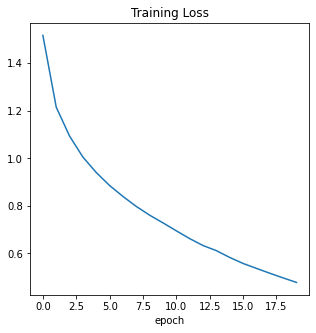

In [6]:
fig, ax = plt.subplots(figsize=(5,5))
ax.plot(loss_)
ax.set_title('Training Loss')
ax.set_xlabel('epoch')
plt.show()

In [7]:
# 모델 저장하기
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

In [8]:
# 모델 불러오기
net = Net().to(device)
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [9]:
# 모델 정확도 구하기
correct = 0
total = 0

with torch.no_grad():
    net.eval()
    for data in test_loader:
        images, labels = data[0].to(device), data[1].to(device)

        total += len(labels)
        outputs = net(images)
        predicted = torch.max(outputs, axis=1)[1]
        correct += (predicted == labels).sum().item()

print(f"Accuracy: {100*correct/total}%")

Accuracy: 63.82%
